# Advanced Lane Finding 

In this project, I have made my best attempts to address the goals that are given below
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

%matplotlib inline

## Let's look at the sample images given to us

In [2]:
def load_image(img):
    return mpimg.imread(img)

In [3]:
def plot_chess_image(image):
#     img = mpimg.imread('camera_cal/calibration'+str(num)+'.jpg')
    img = load_image(image)
    image_shape = img.shape
    print('Shape of the image is: '+str(image_shape))
    plt.imshow(img)

Shape of the image is: (720, 1280, 3)


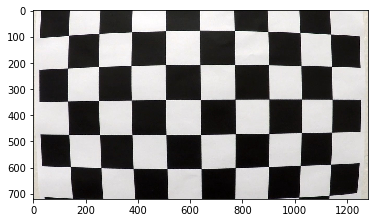

In [4]:
plot_chess_image('camera_cal/calibration1.jpg')

Shape of the image is: (720, 1280, 3)


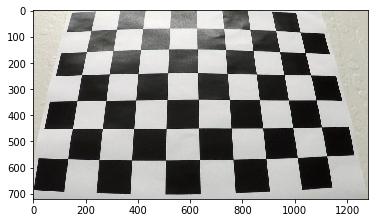

In [6]:
plot_chess_image('camera_cal/calibration3.jpg')

Shape of the image is: (720, 1280, 3)


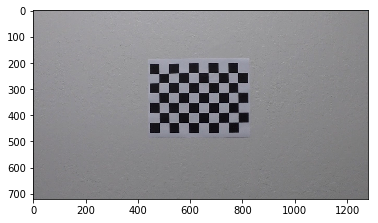

In [7]:
plot_chess_image('camera_cal/calibration6.jpg')

As we understand that the number of points of interest, are "corners" they're only points where two black and two white squares intersect, in other words, only count inside corners, not outside corners i.e. the inside points, not the outside points, we can observe that there are 9 corners in a row and 6 corners in a column.

So we define, 
number of points in x `nx` = 9<br>
number of points in x `ny` = 6

In [8]:
nx = 9
ny = 6

Let's understand how to draw the corners of the chessboard given in the images

In [18]:
def draw_corners(recd_img):
    img = cv2.imread(recd_img) # recd_img is the filename of the file of interest
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, draw corners
    if ret == True:
        print('Corners found, find the image below:')
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
    else:
        print('Corners Not Found')

Corners found, find the image below:


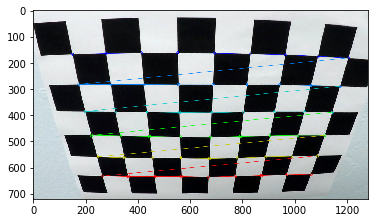

In [19]:
draw_corners('camera_cal/calibration2.jpg')

Let's try to compute the camera calibration matrix<br>
Also, let's find out the distortion coefficients.

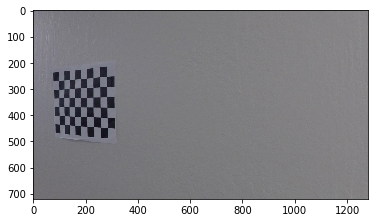

In [20]:
objpoints = []
imgpoints = []

# over here an image in x,y,z dimensions is getting generated
objp = np.zeros((nx*ny,3), np.float32) # here we leave the z coordinate as it remains 0 by default and we don't need z axis
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # here we get the coordinates of the grid size and we tarnspose it

fnames = glob.glob("camera_cal/calibration*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # converting to grayscale
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None) # feeding gray image to find corners
    if ret:
        objpoints.append(objp) # object points are detected and appended here, we will use them to calibrate camera
        imgpoints.append(corners) # corners are detected and appended here
        

In [36]:
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [37]:
def image_dist_undist(num):
    '''This function is used to plot distorted and undistorted image after calibration'''
    img = mpimg.imread('camera_cal/calibration'+str(num)+'.jpg')
    
    undistorted = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix) # this function undistorts the img
    # undistorted is the undistorted or destination image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

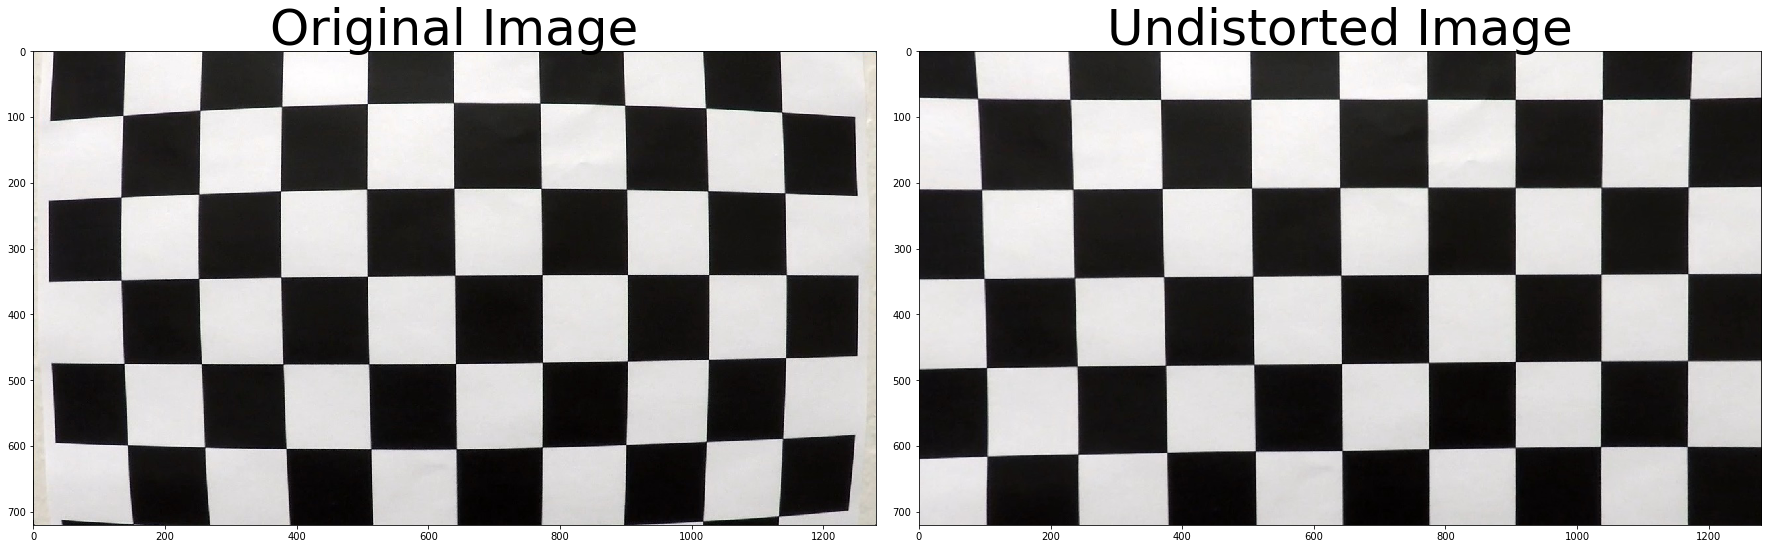

In [38]:
image_dist_undist(1)

In [ ]:
image_dist_undist(2)

if we want to detect the corners and plot them as well, we can use the function `cv2.drawChessboardCorners()`

# Finding the lane curvature,

If our original image is
<img src="files/original_image.png">

1. Detect lane lines using masking and thresholding techniques
<img src="files/thresholded image.png">

2. Then we will perform the perspective transform to get a birds eye view of the lane.
<img src="files/perspective transform.png">

The above steps let's us fit a polynomial to the lane lines. This was not possible in the previous project. Now if we encounter any curved lines also, we would be able to detect them.
3. Then we can extract the curvature of the lines from this polynomial.
<img src="files/finding curvature.png">

# A little about perspectives

The phenomenon where the Objects appear smaller the farther it is away from the viewpoint and parallel lines seem to converse at a point.

in an image, the points farther from the camera would be appearing smaller in size and the objects closer to it would be larger in appearance, so we can understand from the computer vision point of view that, since our coordinates start from the top left corner, the objects which are closer would have larger values of z value the smaller it would appear in a 2D image.

So perspective transform makes the image a proper 2D image which has it's z coordinates 0 or even. For example,
<img src="files/perspective_transform1.png">

With this we can get the bird's eye view of the image. Which makes it easier for us to perform the curvature finding of the lines.

Till now we were doing the undistortion of the chess board which essentially gave us the output
<img src="files/perspective_transform3.png">

but now we intend to solve the problem of actual image for example,
<img src=files/perspective_transform2.png>

How to achieve the linear transformation of any shape.
First we define 4 points that identify a rectangle on the plane of the image which needs a transform and then apply transformation from one perspective to another.

For applying the perspective transform we would need,
1. Source points
2. Destination points

using the function `cv2.getPerspectiveTransform(src, dst)` we can get started for the transformed image, we will call it `M`. This would return us the mapping perspective matrix which we would use to get the transformed image.

we can use `%matplotlib qt` to open an image viewer from where we can get the coordinates

`cv2.warpPerspective(img,M,img_size, flags=cv2.INTER_LINEAR)` is the function which would actually return us the warped image



# Gradient Threshold
Realistically we know well that in Lane Detection we are looking for lines which are tending to be close to vertical (i.e. which can be the lane lines) so using Canny Algorithm wouldn't be of much use.

So we are going to detect the steep edges which are going to be more likely to be lanes in the first place.


# Sobel Operator

To understand how these operators take the derivative, you can think of overlaying either one on a 3 x 3 region of an image. If the image is flat across that region (i.e., there is little change in values across the given region), then the result (summing the element-wise product of the operator and corresponding image pixels) will be zero.

If, instead, for example, you apply the Sobel(x) operator to a region of the image where values are rising from left to right, then the result will be positive, implying a positive derivative.

we pass only a single channel image to the sobel operator so we first convert it to the Grayscale image
<br>
While converting we need to take care of the following points,
- Make sure to use the correct grayscale conversion depending on how we've read in your images. 
- We will Use `cv2.COLOR_RGB2GRAY` if we've read in an image using `mpimg.imread()`. We will Use `cv2.COLOR_BGR2GRAY` if we've read in an image using `cv2.imread().`

### Important points to understand:
<br>

Calculate the derivative in the xx direction (the 1, 0 at the end denotes xx direction):
`sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)`
<br>
Calculate the derivative in the yy direction (the 0, 1 at the end denotes yy direction):
`sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)`
<br>
Calculate the absolute value of the xx derivative:
`abs_sobelx = np.absolute(sobelx)`
<br>
Convert the absolute value image to 8-bit:
`scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))`



# Create a binary threshold to select pixels based on gradient strength:
`thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')`